## *Problem Set 4*
***ECE 685D***: Deep Learning (Fall 2020) <br>
***Full name:*** Guillem Amat Castello

<br>

**Importing Packages**

In [77]:
# General Python packages
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pdb
import os

In [3]:
# Image visualization
import matplotlib.image as mpimg
from PIL import Image

In [8]:
# Torch packages
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch

<br>

### Problem 1: Classification with Convolutional Neural Networks

**Importing and Wrangling Data**

In [159]:
#Loading the labels and converting to torch.Tensor's
objects = {0: 'airplane', 1: 'basket', 2: 'basketball', 3: 'bed', 4: 'bus',
           5: 'calculator', 6: 'cookie', 7: 'eyeglasses', 8:'mushroom', 9: 'pizza'}

train_size = 6000
test_size  = 1000

images_train = []
labels_train = []
images_test  = []
labels_test  = []


for i, label in enumerate(objects):
    images_train.append(torch.Tensor(np.load(os.path.join(os.getcwd(),'Classes', objects[i] + '.npy' ))[:train_size]))
    images_test.append(torch.Tensor(np.load(os.path.join(os.getcwd(),'Classes', objects[i] + '.npy' ))[train_size:train_size+test_size]))
    labels_train.append(torch.ones(train_size).fill_(i))
    labels_test.append(torch.ones(test_size).fill_(i))

In [160]:
X_train = torch.cat(images_train, dim = 0).view(-1, 28, 28).float()
X_test  = torch.cat(images_test, dim = 0).view(-1, 28, 28).float()
y_train = torch.cat(labels_train, dim = 0).long()
y_test  = torch.cat(labels_test, dim = 0).long()

In [161]:
#Transform to Tensor.Dataset to be put into a DataLoader
trainset = torch.utils.data.TensorDataset(X_train.float(), y_train.long())
testset  = torch.utils.data.TensorDataset(X_test.float(), y_test.long())

#Put Tensor into a DataLoader
batch_size  = 500
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

<br>

**Convolutional Neural Network**

In [165]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutions = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
        nn.MaxPool2d(2,2),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1),
        nn.MaxPool2d(2,2),
        nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
        nn.Linear(20 * 7 * 7, 1024), # (channels * width * height) after two pooling operations
        nn.Linear(1024, 2048),
        nn.Linear(2048, 10))
        
    def forward(self, x):
        #pdb.set_trace()
        x = self.convolutions(x)
        x = x.view(-1, 20 * 7 * 7) # Reshape and flatten the data
        x = self.classifier(x)
        return x

In [166]:
model     = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025, weight_decay=0.001)

<br>

**Training and Testing the Model**

In [167]:
#Testing the Net
model.eval()

print('-'*97)
for epoch in range(10):
    
    model.train()
    train_loss = 0; train_accuracy = 0; train_correct  = 0
    for i, data in enumerate(trainloader):
        #pdb.set_trace()
        optimizer.zero_grad()
        
        images, labels = data
        images         = images[:, None, :]
        predictions    = model(images)
        
        loss  = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_loss     += criterion(predictions, labels).item() 
        y_hat          = predictions.argmax(dim=1, keepdim=True)
        train_correct  += y_hat.eq(labels.view_as(y_hat)).sum().item()

    model.eval()
    test_loss = 0; test_accuracy = 0; test_correct  = 0
    for i, data in enumerate(testloader):
        #pdb.set_trace()
        images, labels = data
        images = images[:, None, :]
        
        predictions = model(images)
        
        test_loss     += criterion(predictions, labels).item() 
        y_hat         = predictions.argmax(dim=1, keepdim=True) 
        test_correct  += y_hat.eq(labels.view_as(y_hat)).sum().item()
    
    #pdb.set_trace()
    train_loss     = str((train_loss * batch_size)/len(trainloader.dataset))[:4]
    train_accuracy = str(100 * train_correct / len(trainloader.dataset))[:5]
    test_loss      = str((test_loss * batch_size)/len(testloader.dataset))[:4]
    test_accuracy  = str(100 * test_correct / len(testloader.dataset))[:5]
    
    print(f'''| Epoch: {epoch} | Train Loss: {train_loss} | Train Accuracy: {train_accuracy}% |Test Loss: {test_loss} | Test Accuracy: {test_accuracy}% |''')
    
    print('-'*97)

-------------------------------------------------------------------------------------------------
| Epoch: 0 | Train Loss: 1.18 | Train Accuracy: 72.60% |Test Loss: 0.52 | Test Accuracy: 84.36% |
-------------------------------------------------------------------------------------------------
| Epoch: 1 | Train Loss: 0.46 | Train Accuracy: 85.87% |Test Loss: 0.45 | Test Accuracy: 86.74% |
-------------------------------------------------------------------------------------------------
| Epoch: 2 | Train Loss: 0.41 | Train Accuracy: 87.55% |Test Loss: 0.41 | Test Accuracy: 88.12% |
-------------------------------------------------------------------------------------------------
| Epoch: 3 | Train Loss: 0.37 | Train Accuracy: 88.56% |Test Loss: 0.43 | Test Accuracy: 87.63% |
-------------------------------------------------------------------------------------------------
| Epoch: 4 | Train Loss: 0.35 | Train Accuracy: 89.15% |Test Loss: 0.41 | Test Accuracy: 87.94% |
--------------------

<br>

**Plotting Example Images**

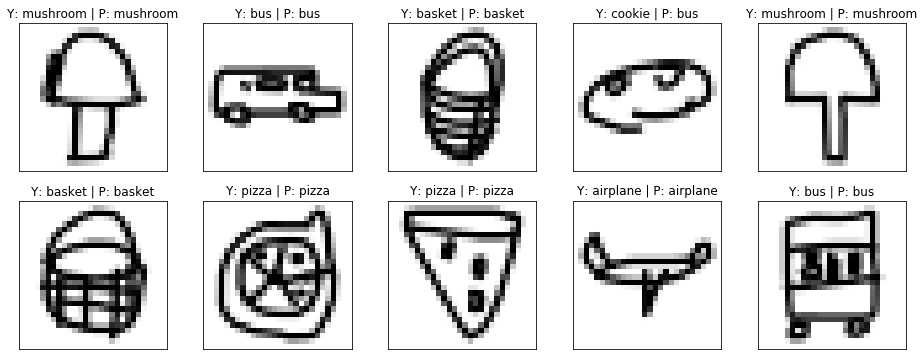

In [188]:
figure, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (16,6))

im=0
for i in range(2):
    for j in range(5):
        axes[i,j].set_title(f'Y: {objects[labels[im].item()]} | P: {objects[y_hat[im].item()]}')
        axes[i, j].imshow(images[:im+1][-1, -1, :], cmap='Greys')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])
        im += 1

Y is the actual class of the Object and P is the predicted class.

<br>

### Problem 2: Feature Extraction Using Autoencoder

In [70]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transform)

In [71]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False)

In [72]:
# Helper function
def Array_to_Image(x):
    x = 0.5*x + 0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x

<br>

**Autoencoder Class**

In [73]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 3)
        )
        
        self.Decoder = nn.Sequential(
            nn.Linear(3, 12, 1),
            nn.ReLU(inplace=True),
            nn.Linear(12, 64, 1),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128, 1),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        
        return encoder, decoder

<br>

**Regular Autoencoder**

In [74]:
AE        = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(), lr=0.001, weight_decay=0.0001)

In [75]:
for epoch in range(25):
    #pdb.set_trace()  
    training_loss = 0
    
    for i, data in enumerate(trainloader):

        optimizer.zero_grad()
        
        images, _ = data
        images    = images.view(images.size(0), -1)
        
        _, output = AE(images)
        loss      = criterion(images, output)
        
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    
    training_loss = str(training_loss/(i+1))[:5]
    if len(str(epoch+1)) > 1:
        print('| Epoch: {} -> Loss: {} |'.format(epoch+1, training_loss))
    else:
        print('| Epoch:  {} -> Loss: {} |'.format(epoch+1, training_loss))

| Epoch:  1 -> Training Loss: 0.339 |
| Epoch:  2 -> Training Loss: 0.230 |
| Epoch:  3 -> Training Loss: 0.211 |
| Epoch:  4 -> Training Loss: 0.202 |
| Epoch:  5 -> Training Loss: 0.191 |
| Epoch:  6 -> Training Loss: 0.180 |
| Epoch:  7 -> Training Loss: 0.170 |
| Epoch:  8 -> Training Loss: 0.165 |
| Epoch:  9 -> Training Loss: 0.162 |
| Epoch: 10 -> Training Loss: 0.160 |
| Epoch: 11 -> Training Loss: 0.158 |
| Epoch: 12 -> Training Loss: 0.157 |
| Epoch: 13 -> Training Loss: 0.155 |
| Epoch: 14 -> Training Loss: 0.154 |
| Epoch: 15 -> Training Loss: 0.152 |
| Epoch: 16 -> Training Loss: 0.151 |
| Epoch: 17 -> Training Loss: 0.150 |
| Epoch: 18 -> Training Loss: 0.149 |
| Epoch: 19 -> Training Loss: 0.148 |
| Epoch: 20 -> Training Loss: 0.147 |
| Epoch: 21 -> Training Loss: 0.146 |
| Epoch: 22 -> Training Loss: 0.145 |
| Epoch: 23 -> Training Loss: 0.144 |
| Epoch: 24 -> Training Loss: 0.144 |
| Epoch: 25 -> Training Loss: 0.143 |


<br>

**Contractive Autoencoder**

In [78]:
CAE       = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(CAE.parameters(), lr=0.001, weight_decay=0.0001)

In [80]:
l = 0.001

for epoch in range(25):
    #pdb.set_trace()  
    training_loss = 0
    
    for i, data in enumerate(trainloader):
        #pdb.set_trace()
        images, _ = data
        images    = images.view(images.size(0), -1)
        images.requires_grad = True
        
        optimizer.zero_grad()
        encoder, output = CAE(images)
        
        loss = criterion(images, output)
        encoder.backward(torch.zeros(encoder.size()), retain_graph=True)
        regularizer = torch.norm(images.grad)
        images.grad.data.zero_()
        regularized_loss = regularizer*l
        loss = loss + regularized_loss
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()

    training_loss = str(training_loss/(i+1))[:5] 
    
    if len(str(epoch+1)) > 1:
        print('| Epoch: {} -> Loss: {} |'.format(epoch+1, training_loss))
    else:
        print('| Epoch:  {} -> Loss: {} |'.format(epoch+1, training_loss))

| Epoch:  1 -> Loss: 0.217 |
| Epoch:  2 -> Loss: 0.201 |
| Epoch:  3 -> Loss: 0.189 |
| Epoch:  4 -> Loss: 0.180 |
| Epoch:  5 -> Loss: 0.174 |
| Epoch:  6 -> Loss: 0.169 |
| Epoch:  7 -> Loss: 0.166 |
| Epoch:  8 -> Loss: 0.163 |
| Epoch:  9 -> Loss: 0.161 |
| Epoch: 10 -> Loss: 0.159 |
| Epoch: 11 -> Loss: 0.157 |
| Epoch: 12 -> Loss: 0.156 |
| Epoch: 13 -> Loss: 0.155 |
| Epoch: 14 -> Loss: 0.153 |
| Epoch: 15 -> Loss: 0.152 |
| Epoch: 16 -> Loss: 0.151 |
| Epoch: 17 -> Loss: 0.150 |
| Epoch: 18 -> Loss: 0.149 |
| Epoch: 19 -> Loss: 0.148 |
| Epoch: 20 -> Loss: 0.148 |
| Epoch: 21 -> Loss: 0.147 |
| Epoch: 22 -> Loss: 0.146 |
| Epoch: 23 -> Loss: 0.146 |
| Epoch: 24 -> Loss: 0.145 |
| Epoch: 25 -> Loss: 0.145 |


<br>

**Principal Component Analysis**

In [81]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [99]:
pca = PCA(n_components = 3)

<br>

**Multiple Logistic Regression**

In [101]:
train = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
test  = torch.utils.data.DataLoader(trainset, batch_size=len(testset))

In [104]:
# Train
image, y_train = next(iter(train))
X_train = image.view(image.size(0), -1) 

# Test
image, y_test = next(iter(test))
X_test = image.view(image.size(0), -1) 

In [120]:
class style:
    start = '\033[1m'
    end = '\033[0m'

<br>

In [136]:
#Regular Autoencoder
with torch.no_grad():
    AE.eval()

    #Train
    encoder, _ = AE(X_train)
    AE_LR      = LogisticRegression(multi_class="multinomial", max_iter=1000)
    AE_LR.fit(encoder, y_train)
    
    #Test
    encoder, _  = AE(X_test)
    predictions = AE_LR.predict(encoder)
    AE_accuracy = metrics.accuracy_score(y_test, predictions)
    AE_accuracy = AE_accuracy*100

In [137]:
print(style.start + 'Accuracy: ' + style.end + f'{AE_accuracy.round(2)}%')

Accuracy: 70.5%


<br>

In [143]:
#Contractive Autoencoder
with torch.no_grad():
    CAE.eval()
    
    #Train
    encoder, _ = CAE(X_train)
    CAE_LR     = LogisticRegression(multi_class="multinomial", max_iter=1000)
    CAE_LR.fit(encoder, y_train)
    
    #Test
    encoder, _   = CAE(X_test)
    predictions  = CAE_LR.predict(encoder)
    CAE_accuracy = metrics.accuracy_score(y_test, predictions)
    CAE_accuracy = CAE_accuracy*100

In [144]:
print(style.start + 'Accuracy: ' + style.end + f'{CAE_accuracy.round(2)}%')

Accuracy: 72.15%


<br>

In [134]:
#Train
components = pca.fit_transform(X_train)
PCA_LR     = LogisticRegression(multi_class="multinomial", max_iter=500)
PCA_LR.fit(components, y_train)

#Test
components   = pca.fit_transform(X_test)
predictions  = PCA_LR.predict(components)
PCA_accuracy = metrics.accuracy_score(y_test, predictions)
PCA_accuracy = PCA_accuracy*100

In [135]:
print(style.start + 'Accuracy: ' + style.end + f'{PCA_accuracy.round(2)}%')

Accuracy: 45.84%
